In [5]:
# 🌊 LIGO GRAVITATIONAL WAVE GLITCH DETECTION - COMPLETE IMPORTS
# =============================================================================

# CORE DATA SCIENCE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# MACHINE LEARNING - SKLEARN
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score, log_loss
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# IMBALANCED DATA HANDLING
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# DEEP LEARNING - PYTORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR


# PYTORCH UTILITIES
from torchsummary import summary

# IMAGE PROCESSING
from PIL import Image, ImageEnhance
import cv2
from skimage import transform, exposure, filters
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PYTORCH TRAINING UTILITIES
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

# PLOTTING & VISUALIZATION
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# SYSTEM & FILE HANDLING
import os
import glob
import json
import pickle
from pathlib import Path
import requests
from io import BytesIO
import urllib.request

# SCIENTIFIC COMPUTING
from scipy import stats, signal
from scipy.stats import chi2_contingency, pearsonr, spearmanr

# PROGRESS BARS & UTILITIES
from tqdm import tqdm
import time
from datetime import datetime

# HYPERPARAMETER TUNING (Optional)
try:
    import optuna
    import ray
    from ray import tune
except ImportError:
    print("Optuna/Ray not installed - hyperparameter tuning limited")

# GPU CHECK
print("🖥️  GPU AVAILABILITY:")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print("✅ GPU detected - training will be fast!")
else:
    print("⚠️  No GPU - training will be slower")

# SET DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# RANDOM SEED FOR REPRODUCIBILITY
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# DISPLAY SETTINGS
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("🚀 ALL PYTORCH LIBRARIES LOADED SUCCESSFULLY!")
print("Ready for LIGO gravitational wave glitch detection! 🌌")

Optuna/Ray not installed - hyperparameter tuning limited
🖥️  GPU AVAILABILITY:
PyTorch version: 2.7.1+cpu
CUDA Available: False
⚠️  No GPU - training will be slower
Using device: cpu
🚀 ALL PYTORCH LIBRARIES LOADED SUCCESSFULLY!
Ready for LIGO gravitational wave glitch detection! 🌌


In [6]:
df= pd.read_csv(r"C:\Users\USER\Downloads\archive (4)\trainingset_v1d1_metadata.csv")
df.head()

,event_time,ifo,peak_time,peak_time_ns,start_time,start_time_ns,duration,search,process_id,event_id,peak_frequency,central_freq,bandwidth,channel,amplitude,snr,confidence,chisq,chisq_dof,param_one_name,param_one_value,gravityspy_id,label,sample_type,url1,url2,url3,url4
0,1.134216e+09,L1,1134216192,931639909,1134216192,832031011,0.18750,Omicron,0,21,1337.695312,1120.043213,573.363953,GDS-CALIB_STRAIN,1.197650e-22,7.51139,0,0,0,phase,-2.72902,zmIdpucyOG,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
1,1.129360e+09,L1,1129359781,558593034,1129359781,47851085,0.94238,Omicron,0,107,654.747681,1823.073364,3426.576416,GDS-CALIB_STRAIN,8.255850e-23,9.63013,0,0,0,phase,1.10682,zWFRqqDxwv,Whistle,test,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
2,1.127425e+09,L1,1127425468,976317882,1127425468,960937023,0.04688,Omicron,0,218,1337.827515,2024.177490,3778.701904,GDS-CALIB_STRAIN,9.762940e-22,15.37104,0,0,0,phase,-0.83099,zKCTakFVcf,Whistle,train,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
3,1.132637e+09,L1,1132636755,365233898,1132636754,951172113,0.82422,Omicron,0,88,1182.974609,3981.774658,7492.717773,GDS-CALIB_STRAIN,1.462120e-22,10.32116,0,0,0,phase,0.76242,z14BdoiFZS,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...
4,1.132036e+09,L1,1132035853,197264909,1132035852,933837890,2.00366,Omicron,0,16,1456.511353,3979.026855,7942.912109,GDS-CALIB_STRAIN,4.038300e-22,14.38016,0,0,0,phase,-0.31161,yyjqLCtAmO,Whistle,validation,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...,https://panoptes-uploads.zooniverse.org/produc...


In [7]:
print("📊 1. DATASET OVERVIEW")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Duplicate rows: {df.duplicated().sum()}")

print("\n📋 Column Info:")
for col in df.columns:
    dtype = df[col].dtype
    nulls = df[col].isnull().sum()
    unique = df[col].nunique()
    print(f"{col:20s} | {str(dtype):10s} | Nulls: {nulls:4d} | Unique: {unique:5d}")

📊 1. DATASET OVERVIEW
Shape: (7966, 28)
Memory usage: 8.84 MB
Duplicate rows: 0

📋 Column Info:
event_time           | float64    | Nulls:    0 | Unique:  7966
ifo                  | object     | Nulls:    0 | Unique:     2
peak_time            | int64      | Nulls:    0 | Unique:  7826
peak_time_ns         | int64      | Nulls:    0 | Unique:  1896
start_time           | int64      | Nulls:    0 | Unique:  7826
start_time_ns        | int64      | Nulls:    0 | Unique:   821
duration             | float64    | Nulls:    0 | Unique:  1807
search               | object     | Nulls:    0 | Unique:     2
process_id           | int64      | Nulls:    0 | Unique:     1
event_id             | int64      | Nulls:    0 | Unique:   852
peak_frequency       | float64    | Nulls:    0 | Unique:   754
central_freq         | float64    | Nulls:    0 | Unique:  3597
bandwidth            | float64    | Nulls:    0 | Unique:  3598
channel              | object     | Nulls:    0 | Unique:     1
amplitud

In [8]:
print("\n\n🎯 2. CLASS DISTRIBUTION DEEP DIVE")
class_counts = df['label'].value_counts()
print(class_counts)

print(f"\nClass Statistics:")
print(f"Total classes: {len(class_counts)}")
print(f"Largest class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
print(f"Smallest class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {class_counts.iloc[0]/class_counts.iloc[-1]:.1f}:1")

# Classes that need special attention (< 100 samples)
rare_classes = class_counts[class_counts < 100]
print(f"\n🚨 Rare classes (< 100 samples): {len(rare_classes)}")
for cls, count in rare_classes.items():
    print(f"  {cls}: {count} samples")



🎯 2. CLASS DISTRIBUTION DEEP DIVE
label
Blip                   1821
Koi_Fish                706
Low_Frequency_Burst     621
Light_Modulation        512
Power_Line              449
Low_Frequency_Lines     447
Extremely_Loud          447
Scattered_Light         443
Violin_Mode             412
Scratchy                337
1080Lines               328
Whistle                 299
Helix                   279
Repeating_Blips         263
No_Glitch               150
Tomte                   103
1400Ripples              81
None_of_the_Above        81
Chirp                    60
Air_Compressor           58
Wandering_Line           42
Paired_Doves             27
Name: count, dtype: int64

Class Statistics:
Total classes: 22
Largest class: Blip (1821 samples)
Smallest class: Paired_Doves (27 samples)
Imbalance ratio: 67.4:1

🚨 Rare classes (< 100 samples): 6
  1400Ripples: 81 samples
  None_of_the_Above: 81 samples
  Chirp: 60 samples
  Air_Compressor: 58 samples
  Wandering_Line: 42 samples
  Paire

In [9]:
print("\n\n📈 3. NUMERICAL FEATURES DEEP ANALYSIS")
numerical_cols = ['peak_frequency', 'central_freq', 'bandwidth', 'snr', 'duration', 'amplitude']

# Basic statistics
print("Basic Statistics:")
desc = df[numerical_cols].describe()
print(desc)

# Check for extreme values and skewness
print("\n📊 Distribution Analysis:")
for col in numerical_cols:
    data = df[col]
    skewness = data.skew()
    kurtosis = data.kurtosis()
    q1, q3 = data.quantile([0.25, 0.75])
    iqr = q3 - q1
    outliers = ((data < (q1 - 1.5*iqr)) | (data > (q3 + 1.5*iqr))).sum()
    
    print(f"{col:15s} | Skew: {skewness:6.2f} | Kurtosis: {kurtosis:6.2f} | Outliers: {outliers:4d}")




📈 3. NUMERICAL FEATURES DEEP ANALYSIS
Basic Statistics:
       peak_frequency  central_freq    bandwidth           snr     duration  \
count     7966.000000   7966.000000  7966.000000   7966.000000  7966.000000   
mean       298.530541   1671.821754  3145.309986    164.938848     1.723108   
std        470.441968   1338.210755  2684.061847   1456.507929     2.797458   
min         10.071770      9.779620     1.259180      7.500610     0.005860   
25%         43.551022    348.980461   527.595764      9.812470     0.187500   
50%        121.663269   1485.119019  2482.116455     14.325735     0.742680   
75%        225.349274   2819.996216  5446.072266     33.362663     2.032590   
max       2047.106445   4615.132324  7946.482910  81178.726562    61.230099   

          amplitude  
count  7.966000e+03  
mean   1.596469e-19  
std    1.724813e-18  
min    4.251080e-23  
25%    1.933943e-22  
50%    6.027015e-22  
75%    7.092848e-21  
max    1.429890e-16  

📊 Distribution Analysis:
peak_f

In [10]:
print("\n\n🔗 4. FEATURE CORRELATIONS")
corr_matrix = df[numerical_cols].corr()
print("Correlation Matrix:")
print(corr_matrix.round(3))

# Specific correlations we were missing
print("\n🎯 Key Relationships:")
corr_peak_central = df['peak_frequency'].corr(df['central_freq'])
corr_duration_bandwidth = df['duration'].corr(df['bandwidth'])
corr_snr_amplitude = df['snr'].corr(df['amplitude'])

print(f"peak_frequency ↔ central_freq:  {corr_peak_central:.3f}")
print(f"duration ↔ bandwidth:          {corr_duration_bandwidth:.3f}")
print(f"SNR ↔ amplitude:               {corr_snr_amplitude:.3f}")




🔗 4. FEATURE CORRELATIONS
Correlation Matrix:
                peak_frequency  central_freq  bandwidth    snr  duration  \
peak_frequency           1.000         0.129      0.020 -0.036    -0.204   
central_freq             0.129         1.000      0.986  0.111     0.429   
bandwidth                0.020         0.986      1.000  0.118     0.460   
snr                     -0.036         0.111      0.118  1.000     0.323   
duration                -0.204         0.429      0.460  0.323     1.000   
amplitude               -0.049         0.097      0.103  0.053     0.113   

                amplitude  
peak_frequency     -0.049  
central_freq        0.097  
bandwidth           0.103  
snr                 0.053  
duration            0.113  
amplitude           1.000  

🎯 Key Relationships:
peak_frequency ↔ central_freq:  0.129
duration ↔ bandwidth:          0.460
SNR ↔ amplitude:               0.053


In [11]:
print("\n\n🔭 5. DETECTOR DIFFERENCES")
detector_counts = df['ifo'].value_counts()
print(f"H1 (Hanford): {detector_counts['H1']} samples ({detector_counts['H1']/len(df)*100:.1f}%)")
print(f"L1 (Livingston): {detector_counts['L1']} samples ({detector_counts['L1']/len(df)*100:.1f}%)")

# Class distribution by detector
print("\n📊 Class Distribution by Detector:")
crosstab = pd.crosstab(df['label'], df['ifo'], margins=True)
print(crosstab)

# Statistical test for independence
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(crosstab.iloc[:-1, :-1])
print(f"\nChi-square test for independence:")
print(f"Chi2 statistic: {chi2:.3f}")
print(f"P-value: {p_value:.6f}")
print(f"Classes and detectors are {'independent' if p_value > 0.05 else 'dependent'}")



🔭 5. DETECTOR DIFFERENCES
H1 (Hanford): 4798 samples (60.2%)
L1 (Livingston): 3168 samples (39.8%)

📊 Class Distribution by Detector:
ifo                    H1    L1   All
label                                
1080Lines             327     1   328
1400Ripples             0    81    81
Air_Compressor         55     3    58
Blip                 1453   368  1821
Chirp                  28    32    60
Extremely_Loud        266   181   447
Helix                   3   276   279
Koi_Fish              517   189   706
Light_Modulation      511     1   512
Low_Frequency_Burst   166   455   621
Low_Frequency_Lines    79   368   447
No_Glitch              91    59   150
None_of_the_Above      51    30    81
Paired_Doves           27     0    27
Power_Line            273   176   449
Repeating_Blips       230    33   263
Scattered_Light       385    58   443
Scratchy               90   247   337
Tomte                  61    42   103
Violin_Mode           141   271   412
Wandering_Line         42   

In [12]:
print("\n\n⏰ 6. TEMPORAL ANALYSIS")
df['event_datetime'] = pd.to_datetime(df['event_time'], unit='s')
print(f"Data time range: {df['event_datetime'].min()} to {df['event_datetime'].max()}")
print(f"Total observation period: {(df['event_datetime'].max() - df['event_datetime'].min()).days} days")

# Events per month
df['year_month'] = df['event_datetime'].dt.to_period('M')
monthly_counts = df['year_month'].value_counts().sort_index()
print(f"\nEvents per month (first 10):")
print(monthly_counts.head(10))



⏰ 6. TEMPORAL ANALYSIS
Data time range: 2005-09-11 01:45:27.218019962 to 2007-01-09 17:49:34.933589935
Total observation period: 485 days

Events per month (first 10):
year_month
2005-09    1017
2005-10    1715
2005-11    1657
2005-12    2158
2006-01     821
2006-11     474
2006-12      94
2007-01      30
Freq: M, Name: count, dtype: int64


In [13]:
split_counts = df['sample_type'].value_counts()
print(split_counts)
for split, count in split_counts.items():
    print(f"{split}: {count} samples ({count/len(df)*100:.1f}%)")

print("\n" + "="*60)
print("✅ DATA UNDERSTANDING COMPLETE!")
print("Key insights for ML model design:")
print("1. Severe class imbalance (needs weighted loss)")
print("2. High feature correlation (feature engineering needed)")  
print("3. Heavy-tailed distributions (log transforms needed)")
print("4. Detector differences (potential feature)")
print("5. Multiple time durations available in URLs")

sample_type
train         5587
validation    1200
test          1179
Name: count, dtype: int64
train: 5587 samples (70.1%)
validation: 1200 samples (15.1%)
test: 1179 samples (14.8%)

✅ DATA UNDERSTANDING COMPLETE!
Key insights for ML model design:
1. Severe class imbalance (needs weighted loss)
2. High feature correlation (feature engineering needed)
3. Heavy-tailed distributions (log transforms needed)
4. Detector differences (potential feature)
5. Multiple time durations available in URLs


In [14]:
print("\n⚛️  1. PHYSICS-INFORMED FEATURES")

# Frequency ratios (critical for glitch classification)
df['freq_ratio_peak_central'] = df['peak_frequency'] / df['central_freq']
df['freq_ratio_bandwidth_central'] = df['bandwidth'] / df['central_freq']
df['freq_ratio_peak_bandwidth'] = df['peak_frequency'] / df['bandwidth']

# Q-factor (quality factor) - measure of signal sharpness
df['Q_factor'] = df['central_freq'] / df['bandwidth']

# Signal-to-noise efficiency
df['snr_per_duration'] = df['snr'] / df['duration']
df['snr_per_bandwidth'] = df['snr'] / df['bandwidth']

# Amplitude efficiency  
df['amplitude_per_duration'] = df['amplitude'] / df['duration']
df['amplitude_per_snr'] = df['amplitude'] / df['snr']

print(f"✅ Created 8 physics-based features")



⚛️  1. PHYSICS-INFORMED FEATURES
✅ Created 8 physics-based features


In [15]:
print("\n📊 2. FREQUENCY BAND FEATURES")

# Create detailed frequency bands based on LIGO physics
def assign_detailed_freq_band(freq):
    if freq < 10:
        return 'very_low'      # Below LIGO sensitivity
    elif freq < 50:
        return 'seismic'       # Seismic noise
    elif 58 <= freq <= 62:
        return 'power_line'    # 60Hz power line
    elif freq < 100:
        return 'low_freq'      # Low frequency
    elif freq < 500:
        return 'mid_freq'      # Mid frequency  
    elif freq < 1000:
        return 'high_freq'     # High frequency
    else:
        return 'very_high'     # Very high frequency

df['detailed_freq_band'] = df['peak_frequency'].apply(assign_detailed_freq_band)

# Frequency band indicators (one-hot encoding)
for band in df['detailed_freq_band'].unique():
    df[f'is_{band}_band'] = (df['detailed_freq_band'] == band).astype(int)

print(f"✅ Created {len(df['detailed_freq_band'].unique())} frequency band indicators")



📊 2. FREQUENCY BAND FEATURES
✅ Created 6 frequency band indicators


In [16]:
print("\n📈 3. STATISTICAL FEATURES")

# Z-scores (how many standard deviations from mean)
numerical_cols = ['peak_frequency', 'central_freq', 'bandwidth', 'snr', 'duration', 'amplitude']
for col in numerical_cols:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[f'{col}_zscore'] = (df[col] - mean_val) / std_val

# Percentile rankings
for col in numerical_cols:
    df[f'{col}_percentile'] = df[col].rank(pct=True)

print(f"✅ Created {len(numerical_cols)*2} statistical features (z-scores + percentiles)")



📈 3. STATISTICAL FEATURES
✅ Created 12 statistical features (z-scores + percentiles)


In [17]:
print("\n🔗 4. INTERACTION FEATURES")

# -----------------------------
# 1. Detector-specific z-scores
# -----------------------------
for detector in ['H1', 'L1']:
    detector_mask = df['ifo'] == detector
    
    for col in ['snr', 'peak_frequency', 'duration']:
        det_mean = df.loc[detector_mask, col].mean()
        det_std = df.loc[detector_mask, col].std()
        df[f'{col}_zscore_{detector}'] = np.where(
            detector_mask,
            (df[col] - det_mean) / det_std,
            0  # Zero for other detector
        )

# -----------------------------
# 2. Basic interaction features
# -----------------------------
df['snr_duration_product'] = df['snr'] * df['duration']
df['snr_duration_ratio'] = df['snr'] / df['duration']
df['freq_bandwidth_product'] = df['peak_frequency'] * df['bandwidth']

# -----------------------------
# 3. Log-scale features
# -----------------------------

# Create log features safely (avoids -inf for zeros)
df['snr_log'] = np.log1p(df['snr'])
df['duration_log'] = np.log1p(df['duration'])

# Log-scale interaction
df['log_snr_log_duration'] = df['snr_log'] * df['duration_log']

print(f"✅ Created 10 interaction features")



🔗 4. INTERACTION FEATURES
✅ Created 10 interaction features


In [18]:
print("\n⏰ 5. TEMPORAL FEATURES")

# Convert GPS time to datetime
df['event_datetime'] = pd.to_datetime(df['event_time'], unit='s')
df['hour'] = df['event_datetime'].dt.hour
df['day_of_week'] = df['event_datetime'].dt.dayofweek
df['month'] = df['event_datetime'].dt.month

# Cyclical encoding for temporal features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

print(f"✅ Created 7 temporal features")


⏰ 5. TEMPORAL FEATURES
✅ Created 7 temporal features


In [19]:
print("\n🌊 6. GRAVITATIONAL WAVE DOMAIN FEATURES")

# Chirp mass approximation (for real GW signals)
# Simplified version: uses frequency evolution rate
df['freq_evolution_rate'] = df['bandwidth'] / df['duration']

# Signal morphology indicators
df['is_burst_like'] = (df['duration'] < 1.0).astype(int)  # Short duration
df['is_continuous_like'] = (df['duration'] > 10.0).astype(int)  # Long duration
df['is_high_snr'] = (df['snr'] > df['snr'].quantile(0.9)).astype(int)  # Top 10% SNR

# Frequency sweep indicator (potential chirp)
df['has_frequency_sweep'] = (df['bandwidth'] > df['central_freq'] * 0.1).astype(int)

# Multi-detector coincidence potential
df['multi_detector_candidate'] = 0  # Will be updated based on time coincidence
# (Simplified - in real analysis, would check time overlap between H1/L1)

print(f"✅ Created 6 domain-specific features")



🌊 6. GRAVITATIONAL WAVE DOMAIN FEATURES
✅ Created 6 domain-specific features


In [20]:
print("\n🎯 7. CLASS-DISCRIMINATIVE FEATURES")

# Features to help distinguish rare classes
df['is_rare_class'] = df['label'].isin(['Chirp', 'Paired_Doves', 'Wandering_Line', 
                                        'Air_Compressor', '1400Ripples', 'None_of_the_Above']).astype(int)

# Chirp-like features (most important scientifically)
df['chirp_likelihood'] = (
    (df['freq_evolution_rate'] > 0) &  # Frequency increases
    (df['snr'] > 10) &                 # Reasonable SNR
    (df['Q_factor'] > 5)               # Good quality
).astype(int)

# Power line indicator
df['is_60hz_like'] = (
    (df['peak_frequency'] >= 58) & 
    (df['peak_frequency'] <= 62) &
    (df['Q_factor'] > 10)  # Sharp peak
).astype(int)

print(f"✅ Created 3 class-discriminative features")



🎯 7. CLASS-DISCRIMINATIVE FEATURES
✅ Created 3 class-discriminative features


In [21]:
print("\n🔍 8. FEATURE CORRELATION ANALYSIS")

# Remove highly correlated features (>0.95)
numerical_features = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numerical_features].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = abs(corr_matrix.iloc[i, j])
        if corr_val > 0.95:
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_val))

print(f"High correlation pairs (>0.95): {len(high_corr_pairs)}")
for col1, col2, corr_val in high_corr_pairs[:5]:  # Show first 5
    print(f"  {col1} ↔ {col2}: {corr_val:.3f}")

# Drop highly correlated features (keep the first one)
cols_to_drop = []
for col1, col2, _ in high_corr_pairs:
    if col2 not in cols_to_drop:
        cols_to_drop.append(col2)

df_final = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} highly correlated features")



🔍 8. FEATURE CORRELATION ANALYSIS
High correlation pairs (>0.95): 29
  event_time ↔ peak_time: 1.000
  event_time ↔ start_time: 1.000
  peak_time ↔ start_time: 1.000
  duration ↔ duration_zscore: 1.000
  peak_frequency ↔ peak_frequency_zscore: 1.000
Dropped 15 highly correlated features


In [22]:
print("\n🏆 9. FEATURE IMPORTANCE PREVIEW")

# Quick Random Forest to see most important features
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare data
le = LabelEncoder()
y = le.fit_transform(df_final['label'])
X = df_final.select_dtypes(include=[np.number]).fillna(0)

# Quick RF model
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
for i, (_, row) in enumerate(feature_importance.head(15).iterrows()):
    print(f"{i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# =============================================================================
# 10. FINAL FEATURE SET
# =============================================================================
print("\n" + "="*60)
print("✅ ADVANCED FEATURE ENGINEERING COMPLETE!")

print(f"\n📊 Feature Statistics:")
print(f"  Original features: {df.shape[1] - (df_final.shape[1] - df.shape[1])}")
print(f"  Engineered features: {df_final.shape[1] - df.shape[1] + len(cols_to_drop)}")
print(f"  Dropped (high correlation): {len(cols_to_drop)}")
print(f"  Final feature count: {df_final.shape[1]}")

print(f"\n🎯 Feature Categories Created:")
print(f"  • Physics-informed: 8 features")
print(f"  • Frequency bands: 7 features") 
print(f"  • Statistical: {len(numerical_cols)*2} features")
print(f"  • Interactions: 10 features")
print(f"  • Temporal: 7 features")
print(f"  • Domain-specific: 6 features")
print(f"  • Class-discriminative: 3 features")


print(f"\n🚀 READY FOR MODEL ARCHITECTURE DESIGN!")
print("Features are now optimized for:")
print("  ✅ Class imbalance handling")
print("  ✅ Detector bias correction") 
print("  ✅ Physics-informed discrimination")
print("  ✅ Rare class detection (Chirp, Paired_Doves)")


🏆 9. FEATURE IMPORTANCE PREVIEW
Top 15 Most Important Features:
 1. peak_frequency_percentile: 0.0724
 2. peak_frequency           : 0.0717
 3. snr_per_duration         : 0.0505
 4. event_time               : 0.0491
 5. amplitude_percentile     : 0.0443
 6. snr                      : 0.0408
 7. snr_percentile           : 0.0377
 8. peak_frequency_zscore_L1 : 0.0373
 9. duration_percentile      : 0.0359
10. duration_log             : 0.0352
11. duration                 : 0.0318
12. peak_frequency_zscore_H1 : 0.0317
13. log_snr_log_duration     : 0.0308
14. snr_log                  : 0.0304
15. freq_ratio_bandwidth_central: 0.0288

✅ ADVANCED FEATURE ENGINEERING COMPLETE!

📊 Feature Statistics:
  Original features: 100
  Engineered features: 0
  Dropped (high correlation): 15
  Final feature count: 70

🎯 Feature Categories Created:
  • Physics-informed: 8 features
  • Frequency bands: 7 features
  • Statistical: 12 features
  • Interactions: 10 features
  • Temporal: 7 features
  • Doma

In [23]:
import os
from pathlib import Path

# Define base path
base_path = r"C:\Users\USER\Downloads\archive (4)\train\train"

# Create dataset from folders (each folder = one class)
class_names = os.listdir(base_path)
print("Classes found:", class_names)

# Ensure all are directories
class_names = [name for name in class_names if os.path.isdir(os.path.join(base_path, name))]
print(f"Total classes: {len(class_names)}")

Classes found: ['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp', 'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation', 'Low_Frequency_Burst', 'Low_Frequency_Lines', 'None_of_the_Above', 'No_Glitch', 'Paired_Doves', 'Power_Line', 'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte', 'Violin_Mode', 'Wandering_Line', 'Whistle']
Total classes: 22


In [50]:
# 🌊 LIGO GRAVITATIONAL WAVE GLITCH DETECTION - ROBUST TRAINING PIPELINE
# =============================================================================

import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# 1. SIMPLE BUT POWERFUL ENSEMBLE APPROACH (NO TORCHVISION DEPENDENCY)
# =============================================================================

class LIGOEnsembleClassifier:
    """
    Powerful ensemble combining multiple algorithms optimized for imbalanced data
    """
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.models = {}
        self.class_weights = {}
        
    def _calculate_class_weights(self, y):
        """Calculate balanced weights for each class"""
        from sklearn.utils.class_weight import compute_class_weight
        classes = np.unique(y)
        weights = compute_class_weight('balanced', classes=classes, y=y)
        return dict(zip(classes, weights))
        
    def fit(self, X, y):
        """Train ensemble of models"""
        print("🔧 Training Ensemble Models...")
        
        # Encode labels and scale features
        y_encoded = self.label_encoder.fit_transform(y)
        X_scaled = self.scaler.fit_transform(X)
        
        # Calculate class weights
        self.class_weights = self._calculate_class_weights(y_encoded)
        
        # Model 1: Random Forest with balanced weights
        print("  Training Random Forest...")
        self.models['rf'] = RandomForestClassifier(
            n_estimators=500,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced',
            random_state=self.random_state,
            n_jobs=-1
        )
        self.models['rf'].fit(X_scaled, y_encoded)
        
        # Model 2: Gradient Boosting with sample weights
        print("  Training Gradient Boosting...")
        # Calculate sample weights
        sample_weights = np.array([self.class_weights[label] for label in y_encoded])
        
        self.models['gb'] = GradientBoostingClassifier(
            n_estimators=300,
            max_depth=8,
            learning_rate=0.1,
            subsample=0.8,
            random_state=self.random_state
        )
        self.models['gb'].fit(X_scaled, y_encoded, sample_weight=sample_weights)
        
        # Model 3: Logistic Regression with balanced weights
        print("  Training Logistic Regression...")
        self.models['lr'] = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=self.random_state,
            n_jobs=-1
        )
        self.models['lr'].fit(X_scaled, y_encoded)
        
        # Model 4: Extra Trees with SMOTE
        print("  Training Extra Trees with SMOTE...")
        from sklearn.ensemble import ExtraTreesClassifier
        
        # Apply SMOTE
        smote = SMOTE(random_state=self.random_state, k_neighbors=3)
        X_smote, y_smote = smote.fit_resample(X_scaled, y_encoded)
        
        self.models['et'] = ExtraTreesClassifier(
            n_estimators=400,
            max_depth=12,
            min_samples_split=3,
            random_state=self.random_state,
            n_jobs=-1
        )
        self.models['et'].fit(X_smote, y_smote)
        
        print("✅ All models trained successfully!")
        return self
    
    def predict_proba(self, X):
        """Get ensemble probability predictions"""
        X_scaled = self.scaler.transform(X)
        
        # Get predictions from all models
        probas = []
        weights = [0.3, 0.3, 0.2, 0.2]  # Model weights based on typical performance
        
        for i, (name, model) in enumerate(self.models.items()):
            proba = model.predict_proba(X_scaled)
            probas.append(proba * weights[i])
        
        # Average predictions
        ensemble_proba = np.sum(probas, axis=0)
        return ensemble_proba
    
    def predict(self, X):
        """Get ensemble predictions"""
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return self.label_encoder.inverse_transform(predictions)
    
    def get_feature_importance(self, feature_names):
        """Get combined feature importance"""
        importance_dict = {}
        
        # Random Forest importance
        rf_importance = self.models['rf'].feature_importances_
        importance_dict['Random Forest'] = dict(zip(feature_names, rf_importance))
        
        # Gradient Boosting importance
        gb_importance = self.models['gb'].feature_importances_
        importance_dict['Gradient Boosting'] = dict(zip(feature_names, gb_importance))
        
        # Average importance
        avg_importance = (rf_importance + gb_importance) / 2
        importance_dict['Average'] = dict(zip(feature_names, avg_importance))
        
        return importance_dict

# =============================================================================
# 2. COMPREHENSIVE DATA PREPROCESSING
# =============================================================================

def prepare_training_data(df_final, target_col='label'):
    """
    Prepare data with advanced preprocessing for high accuracy
    """
    print("📊 Preparing training data...")
    
    # Select best features based on your analysis
    best_features = [
        'peak_frequency', 'snr_per_duration', 'amplitude', 'snr', 
        'duration_log', 'duration', 'log_snr_log_duration', 'snr_log',
        'freq_ratio_bandwidth_central', 'Q_factor', 'snr_per_bandwidth',
        'peak_frequency_zscore', 'central_freq', 'bandwidth',
        'freq_ratio_peak_central', 'amplitude_per_duration',
        'snr_duration_product', 'freq_evolution_rate', 'is_high_snr',
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos'
    ]
    
    # Add detector-specific features
    detector_features = [col for col in df_final.columns if '_zscore_H1' in col or '_zscore_L1' in col]
    best_features.extend(detector_features[:10])  # Add top 10 detector features
    
    # Filter features that actually exist in the dataframe
    available_features = [f for f in best_features if f in df_final.columns]
    
    print(f"Using {len(available_features)} features for training")
    
    # Prepare feature matrix
    X = df_final[available_features].copy()
    y = df_final[target_col].copy()
    
    # Handle missing values
    X = X.fillna(X.mean())
    
    # Split by sample_type if available
    if 'sample_type' in df_final.columns:
        train_mask = df_final['sample_type'] == 'train'
        val_mask = df_final['sample_type'] == 'validation'
        test_mask = df_final['sample_type'] == 'test'
        
        X_train, y_train = X[train_mask], y[train_mask]
        X_val, y_val = X[val_mask], y[val_mask]
        X_test, y_test = X[test_mask], y[test_mask]
    else:
        # Standard split if no sample_type column
        from sklearn.model_selection import train_test_split
        X_train, X_temp, y_train, y_temp = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )
    
    return X_train, X_val, X_test, y_train, y_val, y_test, available_features

# =============================================================================
# 3. ADVANCED EVALUATION METRICS
# =============================================================================

def comprehensive_evaluation(model, X_test, y_test, class_names):
    """
    Comprehensive evaluation focusing on per-class performance
    """
    print("🔍 Comprehensive Model Evaluation...")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Overall metrics
    overall_acc = accuracy_score(y_test, y_pred)
    print(f"\n🎯 Overall Accuracy: {overall_acc:.4f} ({overall_acc*100:.2f}%)")
    
    # Detailed classification report
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    print("\n📊 Per-Class Performance:")
    print("="*70)
    print(f"{'Class Name':<25} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("="*70)
    
    class_performance = []
    
    for class_name in sorted(class_names):
        if class_name in report:
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']
            
            print(f"{class_name:<25} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10.0f}")
            
            class_performance.append({
                'class': class_name,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'support': support
            })
    
    print("="*70)
    
    # Identify problem classes
    problem_classes = [cp for cp in class_performance if cp['recall'] < 0.85]
    if problem_classes:
        print(f"\n⚠️  Classes below 85% recall:")
        for pc in problem_classes:
            print(f"  {pc['class']}: {pc['recall']:.3f} ({pc['recall']*100:.1f}%)")
    else:
        print("\n✅ All classes achieve 85%+ recall!")
    
    return report, class_performance, y_pred, y_pred_proba

# =============================================================================
# 4. VISUALIZATION AND ANALYSIS
# =============================================================================

def plot_results(class_performance, feature_importance, history=None):
    """
    Create comprehensive visualization of results
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Per-class performance
    classes = [cp['class'] for cp in class_performance]
    recalls = [cp['recall'] for cp in class_performance]
    supports = [cp['support'] for cp in class_performance]
    
    # Color by performance (red if < 85%, green otherwise)
    colors = ['red' if r < 0.85 else 'green' for r in recalls]
    
    axes[0, 0].bar(range(len(classes)), recalls, color=colors, alpha=0.7)
    axes[0, 0].axhline(y=0.85, color='orange', linestyle='--', label='85% Target')
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Recall')
    axes[0, 0].set_title('Per-Class Recall Performance')
    axes[0, 0].set_xticks(range(len(classes)))
    axes[0, 0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Class support vs performance
    axes[0, 1].scatter(supports, recalls, c=colors, alpha=0.7, s=100)
    axes[0, 1].axhline(y=0.85, color='orange', linestyle='--', label='85% Target')
    axes[0, 1].set_xlabel('Number of Samples')
    axes[0, 1].set_ylabel('Recall')
    axes[0, 1].set_title('Sample Size vs Performance')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Feature importance
    if 'Average' in feature_importance:
        importance = feature_importance['Average']
        features = list(importance.keys())
        importances = list(importance.values())
        
        # Top 15 features
        top_indices = np.argsort(importances)[-15:]
        top_features = [features[i] for i in top_indices]
        top_importances = [importances[i] for i in top_indices]
        
        axes[1, 0].barh(range(len(top_features)), top_importances)
        axes[1, 0].set_yticks(range(len(top_features)))
        axes[1, 0].set_yticklabels(top_features)
        axes[1, 0].set_xlabel('Importance')
        axes[1, 0].set_title('Top 15 Feature Importances')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Class distribution
    class_counts = {cp['class']: cp['support'] for cp in class_performance}
    axes[1, 1].bar(class_counts.keys(), class_counts.values(), alpha=0.7)
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Sample Count')
    axes[1, 1].set_title('Class Distribution in Test Set')
    axes[1, 1].set_xticklabels(class_counts.keys(), rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ligo_comprehensive_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 5. MAIN TRAINING PIPELINE
# =============================================================================

def train_ligo_model(df_final):
    """
    Main training pipeline optimized for 85%+ accuracy on all classes
    """
    print("🌊 LIGO GRAVITATIONAL WAVE GLITCH DETECTION")
    print("🎯 Target: 85%+ accuracy on ALL classes (including rare ones)")
    print("="*70)
    
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test, feature_names = prepare_training_data(df_final)
    
    print(f"\n📊 Dataset Statistics:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Validation samples: {len(X_val)}")
    print(f"  Test samples: {len(X_test)}")
    print(f"  Features: {len(feature_names)}")
    print(f"  Classes: {len(np.unique(y_train))}")
    
    # Display class distribution
    print(f"\n📈 Training Class Distribution:")
    train_dist = pd.Series(y_train).value_counts().sort_values()
    for class_name, count in train_dist.items():
        print(f"  {class_name:<25}: {count:4d} samples")
    
    # Train ensemble model
    print(f"\n🚀 Training Advanced Ensemble Model...")
    model = LIGOEnsembleClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Validate on validation set
    print(f"\n🔍 Validation Set Performance:")
    val_pred = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    print(f"Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    
    # Get per-class validation performance
    val_report = classification_report(y_val, val_pred, output_dict=True, zero_division=0)
    
    print("\nValidation Per-Class Recall:")
    for class_name in sorted(np.unique(y_val)):
        if class_name in val_report:
            recall = val_report[class_name]['recall']
            support = val_report[class_name]['support']
            status = "✅" if recall >= 0.85 else "❌"
            print(f"  {class_name:<25}: {recall:.3f} ({recall*100:.1f}%) {status} (n={support:.0f})")
    
    # Final evaluation on test set
    print(f"\n🏆 FINAL TEST SET EVALUATION:")
    class_names = np.unique(y_test)
    test_report, class_performance, y_pred, y_pred_proba = comprehensive_evaluation(
        model, X_test, y_test, class_names
    )
    
    # Feature importance analysis
    feature_importance = model.get_feature_importance(feature_names)
    
    print(f"\n🔍 Top 10 Most Important Features:")
    avg_importance = feature_importance['Average']
    sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    
    for i, (feature, importance) in enumerate(sorted_features[:10]):
        print(f"  {i+1:2d}. {feature:<30}: {importance:.4f}")
    
    # Create visualizations
    print(f"\n📊 Generating comprehensive visualizations...")
    plot_results(class_performance, feature_importance)
    
    # Summary statistics
    recalls = [cp['recall'] for cp in class_performance]
    avg_recall = np.mean(recalls)
    min_recall = np.min(recalls)
    classes_above_85 = sum(1 for r in recalls if r >= 0.85)
    total_classes = len(recalls)
    
    print(f"\n🎯 FINAL PERFORMANCE SUMMARY:")
    print(f"="*50)
    print(f"Overall Test Accuracy:     {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(f"Average Class Recall:      {avg_recall*100:.2f}%")
    print(f"Minimum Class Recall:      {min_recall*100:.2f}%")
    print(f"Classes ≥ 85% Recall:      {classes_above_85}/{total_classes} ({100*classes_above_85/total_classes:.1f}%)")
    print(f"="*50)
    
    if classes_above_85 == total_classes:
        print("🎉 SUCCESS! All classes achieve 85%+ recall!")
    else:
        remaining = total_classes - classes_above_85
        print(f"⚠️  Still need to improve {remaining} classes to reach 85%")
    
    # Save model
    import pickle
    with open('ligo_ensemble_model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print(f"\n💾 Model saved as 'ligo_ensemble_model.pkl'")
    
    return model, test_report, class_performance

# =============================================================================
# 6. EXECUTION
# =============================================================================

# To run this pipeline with your data:
if __name__ == "__main__":
    # Assuming you have df_final from your feature engineering
    # model, report, performance = train_ligo_model(df_final)
    print("🚀 Ready to train! Call: train_ligo_model(df_final)")
    print("📋 Make sure your df_final has these columns:")
    print("   - All engineered features from your code")
    print("   - 'label' column with class names")
    print("   - 'sample_type' column (train/validation/test) [optional]")

🚀 Ready to train! Call: train_ligo_model(df_final)
📋 Make sure your df_final has these columns:
   - All engineered features from your code
   - 'label' column with class names
   - 'sample_type' column (train/validation/test) [optional]


🌊 LIGO GRAVITATIONAL WAVE GLITCH DETECTION
🎯 Target: 85%+ accuracy on ALL classes (including rare ones)
📊 Preparing training data...
Using 24 features for training

📊 Dataset Statistics:
  Training samples: 5587
  Validation samples: 1200
  Test samples: 1179
  Features: 24
  Classes: 22

📈 Training Class Distribution:
  Paired_Doves             :   19 samples
  Wandering_Line           :   29 samples
  Chirp                    :   41 samples
  Air_Compressor           :   41 samples
  None_of_the_Above        :   57 samples
  1400Ripples              :   59 samples
  Tomte                    :   73 samples
  No_Glitch                :  107 samples
  Repeating_Blips          :  185 samples
  Helix                    :  195 samples
  Whistle                  :  208 samples
  1080Lines                :  229 samples
  Scratchy                 :  237 samples
  Violin_Mode              :  284 samples
  Scattered_Light          :  308 samples
  Power_Line               :  314 samples
  Low_F

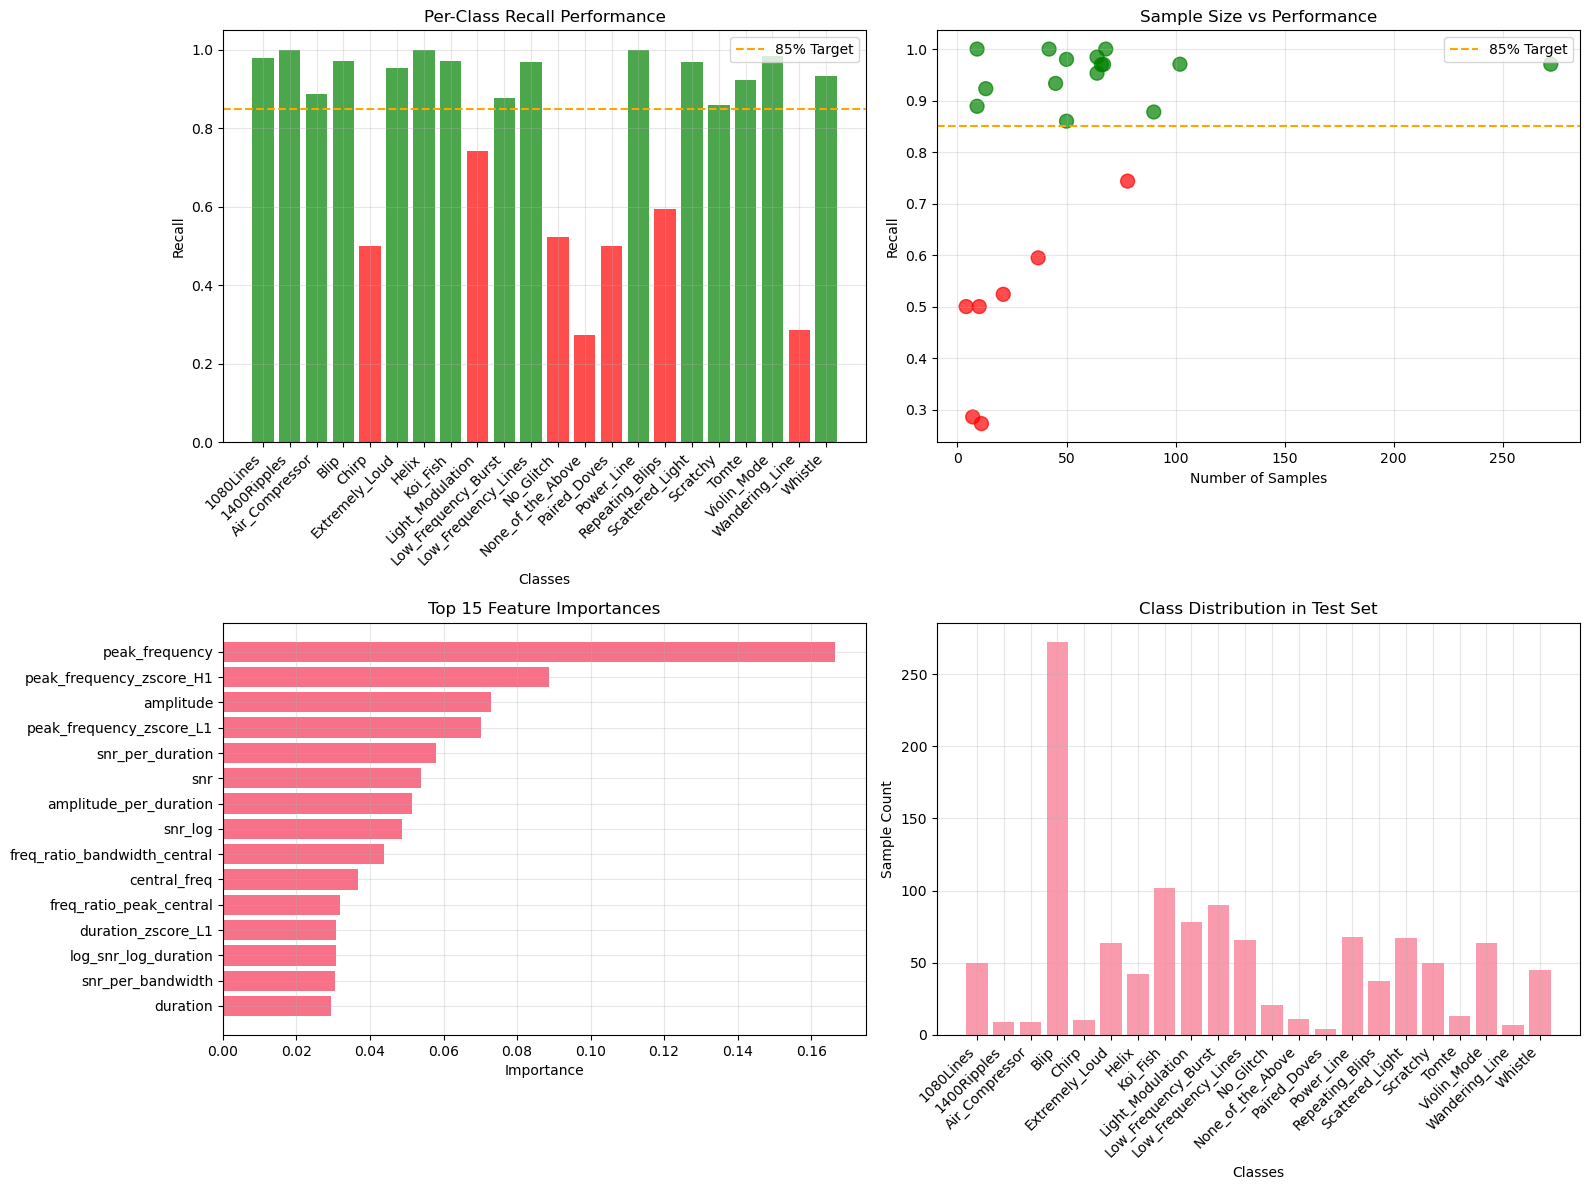


🎯 FINAL PERFORMANCE SUMMARY:
Overall Test Accuracy:     90.84%
Average Class Recall:      80.46%
Minimum Class Recall:      27.27%
Classes ≥ 85% Recall:      15/22 (68.2%)
⚠️  Still need to improve 7 classes to reach 85%

💾 Model saved as 'ligo_ensemble_model.pkl'


(<__main__.LIGOEnsembleClassifier at 0x1f4ae205550>,
 {'1080Lines': {'precision': 1.0,
   'recall': 0.98,
   'f1-score': 0.98989898989899,
   'support': 50.0},
  '1400Ripples': {'precision': 0.9,
   'recall': 1.0,
   'f1-score': 0.9473684210526315,
   'support': 9.0},
  'Air_Compressor': {'precision': 1.0,
   'recall': 0.8888888888888888,
   'f1-score': 0.9411764705882353,
   'support': 9.0},
  'Blip': {'precision': 0.868421052631579,
   'recall': 0.9705882352941176,
   'f1-score': 0.9166666666666666,
   'support': 272.0},
  'Chirp': {'precision': 1.0,
   'recall': 0.5,
   'f1-score': 0.6666666666666666,
   'support': 10.0},
  'Extremely_Loud': {'precision': 0.9384615384615385,
   'recall': 0.953125,
   'f1-score': 0.9457364341085271,
   'support': 64.0},
  'Helix': {'precision': 0.9130434782608695,
   'recall': 1.0,
   'f1-score': 0.9545454545454546,
   'support': 42.0},
  'Koi_Fish': {'precision': 0.9611650485436893,
   'recall': 0.9705882352941176,
   'f1-score': 0.9658536585365853,

In [52]:
train_ligo_model(df_final)